# Detection and Quantification in Holography

In this notebook we will investigate how to detect and quantify particles in Holography. 

The notebook contains the following sections:

1. Imports 
    - Importing the packages needed to run the code.
2. Detection in Holography
    - We leverage two different methods for particle detection: the Radial Variance Transform(RVT) and LodeSTAR.
3. Quantification of particle properties in Holography
    - Here we show how to simulate particles in the Holography regime and train a Convolutional Neural Network(CNN) for the quantification task.
    - We provide figures of how the estimated signal scales with fixed radius aswell as with fixed refractive index and corresponding theoretical curves.
4. Combining detection and quantification in Holography
    - Here we provide a short example on how to analyze an entire frame by performing tracking with LodeSTAR and signal quantification with a CNN.




## 1. Imports

In [2]:
import deeptrack as dt
import deeptrack.deeplay as dl

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import skimage
import torch

In [10]:
import sys
#Sys append a folder to the path
sys.path.append(os.path.join("..", "helper_functions"))

In [11]:
import helpers as hp #Helper functions for the notebook.

In [4]:
DEV = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running code on device: ({DEV}) when possible")

Running code on device: (cuda) when possible


## 2. Detection in Holography

Let's start by loading in data in the quantitiative field regime.

In [5]:
data_path = os.path.join("data", "qf_data.npy")
labels_path = os.path.join("data", "qf_labels.npy")

In [6]:
data = np.load(data_path) #Quantitative field image
labels = np.load(labels_path) #Labels for the particles
centroids = labels[:, 0:2] #Centroids of the particles

In [7]:
#Subtracting mean in the real part so that the data is centered
data[...,0] = data[...,0] - 1

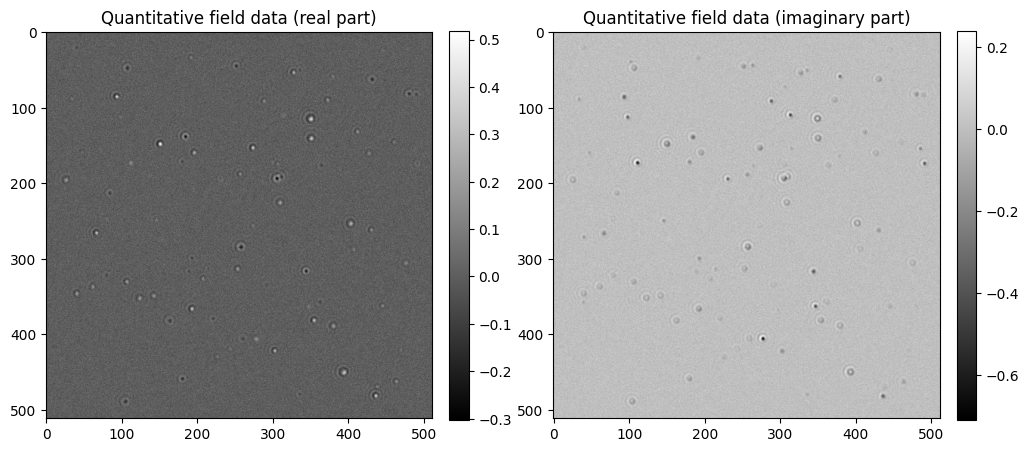

In [8]:
plt.figure(figsize=(12,6))
plt.subplot(121)
im = plt.imshow(data[...,0], cmap="gray")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Quantitative field data (real part)")
plt.subplot(122)
im = plt.imshow(data[...,1], cmap="gray")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Quantitative field data (imaginary part)")
plt.show()

### 2.1 Detecting particles using Radial Variance Transform (RVT)


We present an example demonstrating the use of the Radial Variance Transform (RVT) for particle detection, a method which is highly efficient and has shown great results on particle detection tasks. 

You can find the implementation of this algorithm on GitHub:
[Radial Variance Transform for Particle Detection](https://github.com/SandoghdarLab/rvt)

For a detailed explanation and the research behind this method, refer to the following paper:
["Precision single-particle localization using radial variance transform"](https://opg.optica.org/oe/fulltext.cfm?uri=oe-29-7-11070&id=449504)




#### 2.1.1 Detecting and visualizing the results on the full frame

We construct a pipeline for the RVT method which also incorporates a local maxima step to detect the centroids of the particles. The implementation can be found in the `help_files.py` file.

For own use, please feel free to change parameter settings so optimize to your own data.


In [9]:
###Settings for Radial Variance Transform pipeline
rmin, rmax = 3, 30
th_scale = 1.2
min_distance = 9

In [10]:
detections_rvt = hp.rvt_pipeline(
    data, 
    rmin=rmin, 
    rmax=rmax, 
    th_scale=th_scale, 
    min_distance=min_distance
    )

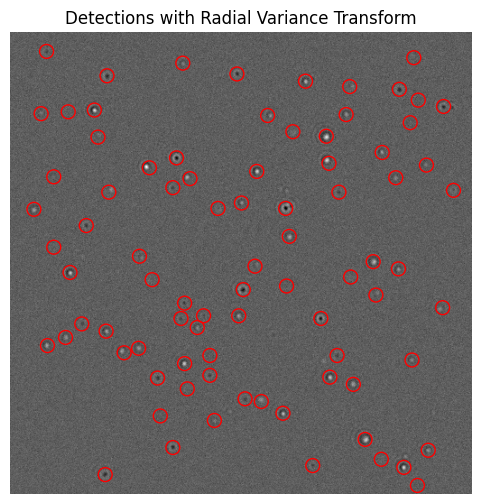

In [11]:
hp.plot_frame_with_detections(
    data=data[...,0],
    positions=detections_rvt,
    title = "Detections with Radial Variance Transform"
    )

To evaluate the accuracy of our particle detection, we calculate the F1-score. By creating a mask of the ground truth particles with a preset radius, we can overlay this ground truth mask with the predicted mask to assess the detection performance.

In [12]:
radius = 6 #Radius of the particle in pixels

In [13]:
GT_particles = hp.add_bin_circles(centroids, radius) #Ground truth particles
P_particles = hp.add_bin_circles(detections_rvt, radius) #Detected particles

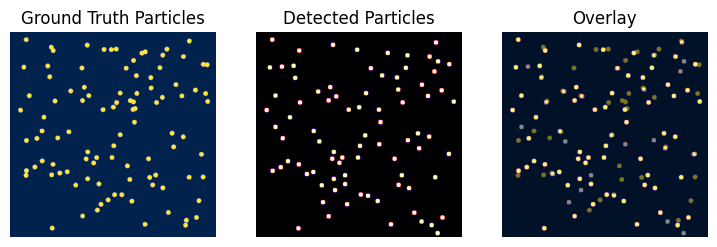

In [14]:
hp.plot_overlay(GT_particles, P_particles)

In [15]:
f1_score_rvt = hp.get_F1_score(P_particles, GT_particles)
print(f"F1 score for RVT: {round(f1_score_rvt * 100, 3)}%")

F1 score for RVT: 69.369%


### 2.2 Detecting particles using LodeSTAR model


We'll explore another approach for detecting particles known as the LodeSTAR method. This method employs a self-supervised neural network model that requires only one or a few training images for particle detection.

For more detailed information about this method, refer to the following paper:
- Midtvedt, B., Pineda, J., Skärberg, F. et al. "Single-shot self-supervised object detection in microscopy." Nat Commun 13, 7492 (2022). [Link to Paper](https://www.nature.com/articles/s41467-022-35004-y)


#### 2.2.1  Prepare the Training Crop
For training the network, we will need to provide one or a few training crops as input.

If applying this to your own data. One approach is to manually extract a few centroids of particles which are in fairly clear view.

In [16]:
crop_size = 40
labels_idx = 11

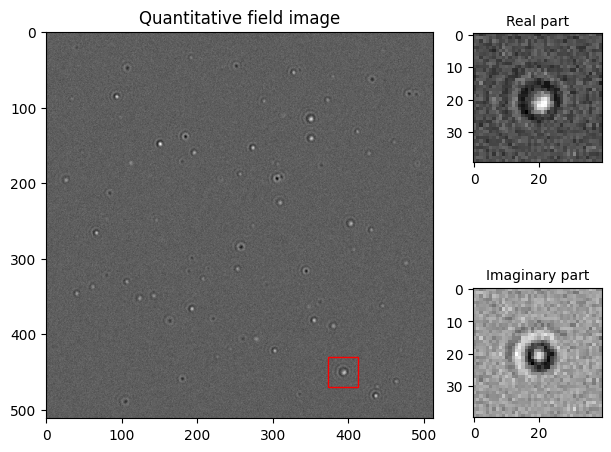

In [17]:
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec

# We crop the image around the particle (based on the labels) - One could also use the detections or manually select a particle.
crop_x0 = int(labels[labels_idx, 0] - crop_size/2)
crop_y0 = int(labels[labels_idx, 1] - crop_size/2)

crop = data[crop_x0:crop_x0 + crop_size, crop_y0:crop_y0 + crop_size, :]

# Create the figure and the grid layout
fig = plt.figure(layout="constrained", figsize=(6, 5))
gs = GridSpec(2, 4, figure=fig)

# Main image
ax1 = fig.add_subplot(gs[:2, :3])
ax1.imshow(data[..., 0], cmap="gray")
ax1.set_title("Quantitative field image")

plt.gca().add_patch(patches.Rectangle((crop_y0, crop_x0), crop_size, crop_size,
                                      linewidth=1, edgecolor="r",
                                      facecolor="none"))

# Crop images
crop_positions = [(0, 3), (1, 3)]
names = ["Real part", "Imaginary part"]
for i, (x, y) in enumerate(crop_positions):
    ax = fig.add_subplot(gs[x, y])
    ax.imshow(crop[..., i], cmap="gray")
    ax.set_title(names[i], fontsize=10)
plt.show()

(-0.5, 39.5, 39.5, -0.5)

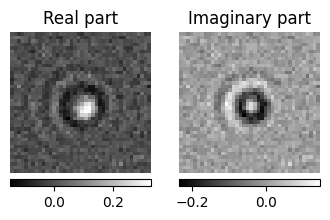

In [18]:
plt.figure(figsize=(4,2))
plt.subplot(1,2,1)
plt.title("Real part", fontsize = 12)
im = plt.imshow(crop[...,0], cmap="gray")
plt.colorbar(im, fraction=0.046, pad=0.04, orientation = "horizontal")
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Imaginary part", fontsize = 12)
im = plt.imshow(crop[...,1], cmap = 'gray')
plt.colorbar(im, fraction=0.046, pad=0.04, orientation = "horizontal")
plt.axis('off')

#### 2.2.2  Prepare pipeline for generating training samples and train the LodeSTAR model
We here create a pipeline for training the LodeSTAR model by adding some noise and scaling of the image values.

The initial noise we apply introduces a gradient onto the image.

In [19]:
IMAGE_SIZE = 40
PADDING = 64
WAVELENGTH = 532e-9
RESOLUTION = 1.14e-7

In [20]:
# Create a meshgrid
X, Y = np.meshgrid(
    np.arange(crop_size)-crop_size,
    np.arange(crop_size)-crop_size
    )

#Gradient function
def grad(dx1,dx2,dy1,dy2):
    "Adds a gradient to the image"
    def inner(image):
        image[...,0]+=dx1*X+dy1*Y
        image[...,1]+=dx2*X+dy2*Y
        return image
    return inner

#Lambda layer which adds a gradient to the image
addgrad=dt.Lambda(
    grad,
    dx1=lambda: .02/40*np.random.randn(),
    dx2=lambda: .02/40*np.random.randn(),
    dy1=lambda: .02/40*np.random.randn(),
    dy2=lambda: .02/40*np.random.randn()
    )

In [21]:
#For z-propagation
crop_propagation_forward = dt.get_propagation_matrix((IMAGE_SIZE + PADDING, ) * 2, 1e-7, RESOLUTION, WAVELENGTH)
crop_propagation_backward = dt.get_propagation_matrix((IMAGE_SIZE + PADDING, ) * 2, -1e-7, RESOLUTION, WAVELENGTH)

#Training pipeline
training_pipeline = (
    dt.Value(crop)
    >> dt.FourierTransform() 
    >> dt.FourierTransformTransformation(crop_propagation_forward, crop_propagation_backward, lambda:np.random.uniform(-7, 7)) 
    >> dt.InverseFourierTransform() 
    >> dt.Multiply(lambda: np.random.uniform(0.1, 3))
    >> dt.Add(lambda: np.random.uniform(-0.1, 0.1))
    >> addgrad
    >> dt.Gaussian(sigma=lambda: np.random.rand() * 1e-3)
    >> dt.MoveAxis(-1, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float32)
)

In [22]:
#Training dataset. Setting the length to 5000 and replace to False.
training_dataset = dt.pytorch.Dataset(training_pipeline, length=5000, replace=False)

# Create a dataloader
dataloader = dl.DataLoader(training_dataset, batch_size=8, shuffle=True)

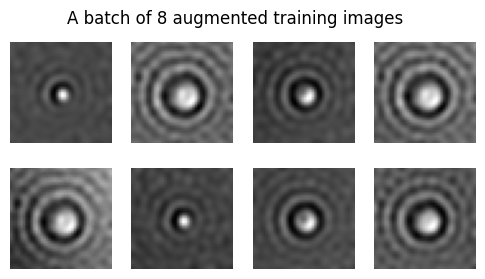

In [23]:
dataloader = dl.DataLoader(training_dataset, batch_size=8, shuffle=True)

batch = next(iter(dataloader))
plt.figure(figsize=(6, 3))
plt.suptitle("A batch of 8 augmented training images")
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(batch[0][i,0], cmap="gray")
    plt.axis("off")

Define and train the LodeSTAR model (or load in a pretrained model).

In [24]:
learning_rate = 2e-4
max_epochs = 50
TRAIN_MODEL = False
model_path = os.path.join("models", "lodestar_tracking.pth")

In [25]:
#Defining the model
lodestar = dl.LodeSTAR(n_transforms=4, optimizer=dl.Adam(lr=learning_rate)).build().to(DEV)

In [26]:
if TRAIN_MODEL:
    #Train model for max_epochs.
    trainer = dl.Trainer(max_epochs=50)
    trainer.fit(lodestar, dataloader)
else:
    lodestar.load_state_dict(torch.load(model_path))
    lodestar.eval()
lodestar = lodestar.to(DEV)


#### 2.2.3  Detect and visualize the results on the full frame

Let's visualize the particle detections on a full frame using the LodeSTAR model. The model includes a detect function, which can identify multiple particles within a full field of view. While some parameter tuning may be necessary, we've provided suitable initial values below.

In [27]:
#Parameters for the tracking
alpha = 0.5
beta = 0.5
cutoff = 0.9825
mode = "quantile" #"constant"

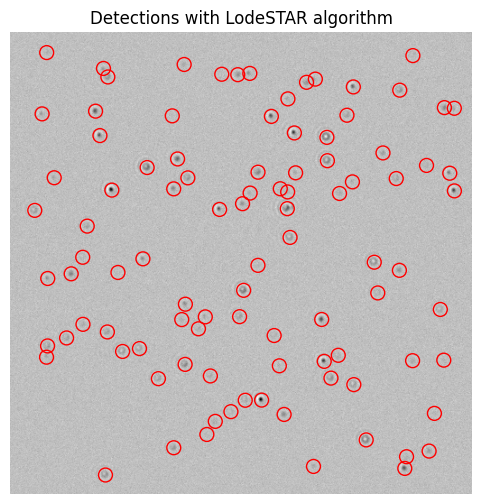

In [28]:
torch_image = torch.from_numpy(data).permute(2, 0, 1).unsqueeze(0).float()
detections = lodestar.detect(torch_image, alpha=alpha, beta=beta, mode=mode, cutoff=cutoff)[0]

hp.plot_frame_with_detections(
    data = data[...,1],
    positions = detections,
    title = "Detections with LodeSTAR algorithm"
    )


To evaluate the accuracy of our particle detection, we calculate the F1-score yet again.

In [29]:
P_particles = hp.add_bin_circles(detections, radius) #Detected particles

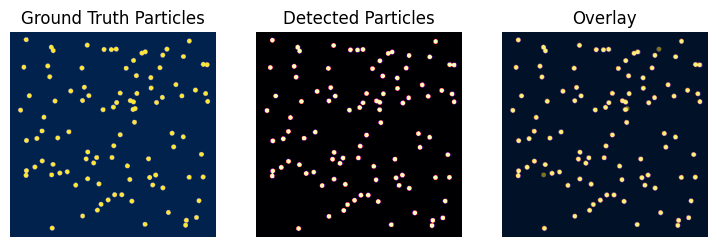

In [30]:
hp.plot_overlay(GT_particles, P_particles)

In [31]:
# F1 score for LodeSTAR
f1_score_l = hp.get_F1_score(P_particles, GT_particles)
print(f"F1 score for LodeSTAR: {round(f1_score_l * 100, 3)}%")

F1 score for LodeSTAR: 84.686%


## 3 - Quantification of particle properties in Quantitiative field imaging

It is now time to move to quantification of the particles. 

To analyze their signal we will look at region of interests (ROIs) around the particles, thus trying to extract the signal of the particles from an image.

In [32]:
padsize = 20 # Padding size, 20 pixels gives a total size of 40x40 pixels.

In [33]:
rois = hp.get_rois(data, centroids, padsize) #Get the ROIs

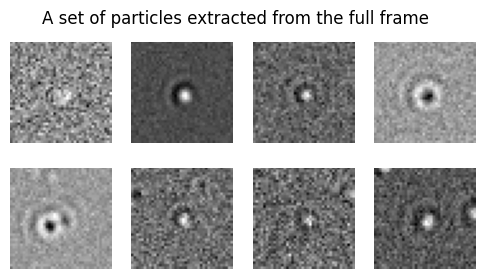

In [34]:
plt.figure(figsize=(6, 3))
plt.suptitle("A set of particles extracted from the full frame")
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(rois[i,...,0], cmap="gray")
    plt.axis("off")

In Holography, the recorded quantity is the scattered field itself, which is then the polarizability.

The polarizability of a particle can be calculated using the following formula:

\begin{equation}
\text{Polarizability} = \frac{3}{2} V \frac{n_{\text{particle}}^2 - n_{\text{medium}}^2}{2n_{\text{medium}}^2 + n_{\text{particle}}^2}
\end{equation}

Where the volume \( V \) of the particle is given by:

\begin{equation}
V = \frac{4}{3} \pi r^3
\end{equation}

where,
* $r$ is the radius of the particle.
* $n_{\text{particle}}$ is the refractive index of the particle.
* $n_{\text{medium}}$ is the refractive index of the medium.


In [35]:
#Calculate the polarizabilities for all the particles
polarizabilities_rois = hp.get_polarizability(labels[:,3]*1e6, labels[:,4])

### 3.2 Quantifying particle signal using a 2DCNN

We will now implement a 2-D Convolutional Neural Network(CNN) to learn how to estimate the polarizability. The input will here be an image of a particles scattering pattern, and the label will be de theoretical polarizability.

#### 3.2.1 Defining the optical system

First of we define the optical system of which we image the particles in.

In [36]:
IMAGE_SIZE = 40
NA = 1
MAGNIFICATION = 1
WAVELENGTH = 532e-9
RESOLUTION = 1.14e-7

In [37]:
optics = dt.Brightfield(
    NA=NA,
    magnification=MAGNIFICATION,
    wavelength=WAVELENGTH,
    resolution=RESOLUTION,
    return_field=True, 
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
)

#### 3.2.2 Defining the particle(s)

We define spherical particles with a radius ranging from 25nm to 250nm and a refractive index ranging from 1.37 to 1.6.

In [38]:
RADIUS_RANGE = (25e-9, 250e-9)
REFRACTIVE_INDEX_RANGE = (1.37, 1.6)

In [39]:
particle = dt.MieSphere(
    position=lambda: (IMAGE_SIZE / 2, IMAGE_SIZE / 2) + np.random.rand(2) * 4 - 2,
    z=lambda: np.random.randn() * 5,
    radius=lambda:np.random.uniform(*RADIUS_RANGE),
    refractive_index=lambda: np.random.uniform(*REFRACTIVE_INDEX_RANGE),
    L=8,
    position_unit="pixel",
    sigmaval=lambda radius: np.random.uniform()*(radius/1e-8)*2e-3,
)

#### 3.2.3 Create dataset of particles

The noise is simulated as gaussian distributed noise, with independent real and imaginary parts. Finally, the real and imaginary parts of the field are separated into two layers, and the plane wave is subtracted. The noise is scaled with radius so that small particles do not disappear when having to high noise.

In [40]:
def complex_to_float_f():
    """Converts a complex image to a float image"""
    def inner(image):
        image = image - 1
        output = np.zeros((*image.shape[:2], 2))
        output[..., 0:1] = np.real(image)
        output[..., 1:2] = np.imag(image)
        return output
    return inner

complex_to_float = dt.Lambda(complex_to_float_f)

In [41]:
dataset = optics(particle) >> dt.Gaussian(sigma=particle.sigmaval + 1j*particle.sigmaval) >> complex_to_float

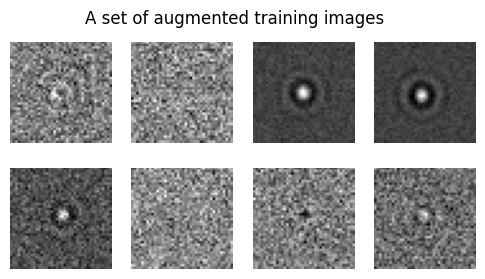

In [42]:
plt.figure(figsize=(6, 3))
plt.suptitle("A set of augmented training images")
for i in range(8):
    plt.subplot(2, 4, i+1)
    img = dataset.update().resolve()
    plt.imshow(img[...,0], cmap="gray")
    plt.axis("off")

#### 3.2.4 Defining the training label

We here define functions to extract the parameters we want the network to learn, i.e. the polarizability.

In [43]:
MIN, MAX = hp.pol_range(RADIUS_RANGE, REFRACTIVE_INDEX_RANGE)
print(f"Min: {MIN}, Max: {MAX}")

Min: 1.958164848627912e-06, Max: 0.01273673470480586


In [44]:
def get_polarizability(radius, refractive_index, nm=1.333):
    """Get the polarizability of a particle
    
    Args:
        radius (float): The radius of the particle in meters.
        refractive_index (float): The refractive index of the particle.
        nm (float): The refractive index of the medium.

    Returns:
        np.ndarray: The polarizability of the particle.
    """

    # Get the polarizability
    pol = hp.get_polarizability(radius=radius*1e6, refractive_index=refractive_index, refractive_index_medium=nm)

    # Normalize the polarizability
    pol = pol / MAX

    return np.expand_dims(pol, -1)

#### 3.2.5 Creating a model (2DCNN) for quantification.

We create a neural network with a convolutional part consisting of 3 layers and a multi-layer perceptron with 2 hidden layers. The network uses leaky ReLU activation functions with a slope of 0.1 for the outputs. We denote that the model architecture can be adjusted as required.

In [45]:
conv = dl.ConvolutionalNeuralNetwork(
    in_channels=2, 
    hidden_channels=[16, 32, 64], 
    out_channels=64,
    pool=dl.torch.nn.MaxPool2d(kernel_size=2),
    out_activation=dl.torch.nn.LeakyReLU(0.1),
    )

mlp = dl.MultiLayerPerceptron(
    in_features=None, 
    hidden_features=[64, 32], 
    out_activation=dl.torch.nn.LeakyReLU(0.1), 
    out_features=1
    )

net = dl.Sequential(
    conv,
    mlp
    )

We define the model as regressor and utilize Mean Absolute Error(MAE) loss with the Adam optimizer.

In [46]:
regressor = dl.Regressor(
    model=net,
    loss=dl.torch.nn.L1Loss(),
    optimizer=dl.Adam(),
)

cnn_regressor = regressor.create()
cnn_regressor = cnn_regressor.to(DEV)

#### 3.2.6 Training of the model

We construct an image-signal pipeline that generates images along with their corresponding labels.

In [47]:
#Pipeline for generating images and labels.
image_and_signal_pipeline = dataset & dataset >> dt.Value(get_polarizability, radius=particle.radius, refractive_index=particle.refractive_index)

In [48]:
#Training dataset
training_dataset = dt.pytorch.Dataset(image_and_signal_pipeline, length=10000, replace=False)
dataloader = dl.DataLoader(training_dataset, batch_size=32, shuffle=True)

#Validation dataset
val_dataset = dt.pytorch.Dataset(image_and_signal_pipeline, length=1000, replace=False)
val_dataloader = dl.DataLoader(val_dataset, batch_size=32, shuffle=True)

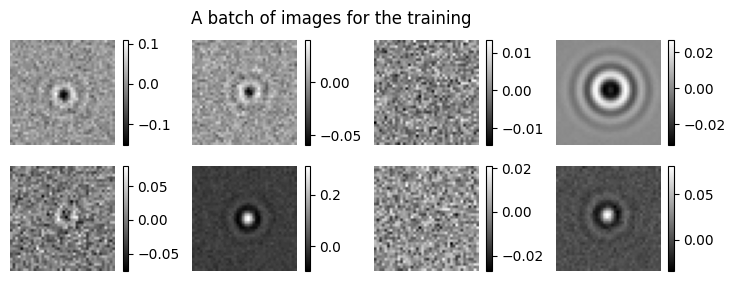

In [49]:
batch = next(iter(dataloader))
plt.figure(figsize=(9, 3))
plt.suptitle("A batch of images for the training")
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(batch[0][i,0], cmap="gray")
    plt.colorbar()
    plt.axis("off")

In [50]:
max_epochs = 300
TRAIN_MODEL = False
model_path = os.path.join("models", "cnn_regressor.pth")

In [51]:
TRAIN_MODEL = False

if TRAIN_MODEL:
    #Train model for max_epochs.
    trainer = dl.Trainer(max_epochs=300)
    trainer.fit(cnn_regressor, dataloader, val_dataloader)
else:
    cnn_regressor.load_state_dict(torch.load(model_path))
    cnn_regressor.eval()
cnn_regressor = cnn_regressor.to(DEV)

#### 3.2.7 Validating the model on simulated data and ROIs from the full frame.

To validate that the model we predict on the valiation set and the ROIs extracted from the full frame


In [52]:
#Predict the signal on validation dataset
predictions = []
labels_ = []
for batch in val_dataloader:
    predictions.append(cnn_regressor(batch[0].to(DEV)))
    labels_.append(batch[1])

#Concatenate the predictions and labels
predictions = torch.concatenate(predictions)[:, 0].detach().cpu().numpy()
labels_ = torch.concatenate(labels_)[:, 0].detach().cpu().numpy()

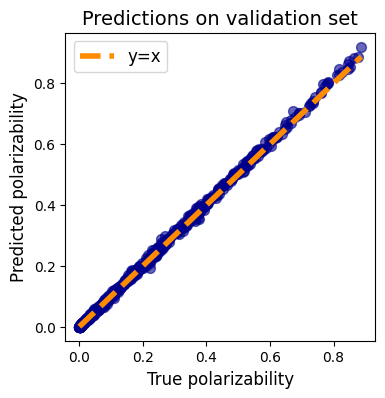

In [53]:
hp.visualize_lab_pred(labels_, predictions, xlabel="True polarizability", ylabel="Predicted polarizability")

In [54]:
#Predict on the rois
predictions_rois = [cnn_regressor(torch.from_numpy(roi).permute(2, 0, 1).unsqueeze(0).float().to(DEV)) for roi in rois]
predictions_rois = np.array([pred.item() for pred in predictions_rois])

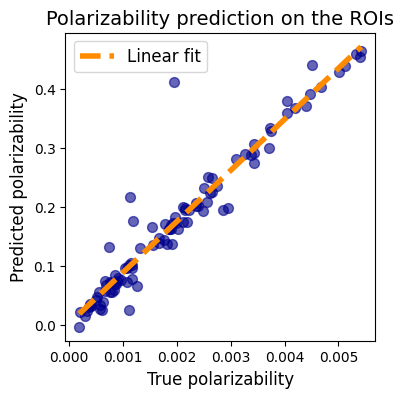

In [55]:
hp.visualize_lab_pred(
    polarizabilities_rois, 
    predictions_rois,
    title="Polarizability prediction on the ROIs",
    xlabel="True polarizability",
    ylabel="Predicted polarizability",
    linfit=True
    )

### 3.4 We investigate the signal's dependence while fixing either the refractive index or the radius.

In the following section the signal dependence in two scenarios is analyzed 1. Fixed refractive index, 2. Fixed radius

#### 3.4.1 Fix refractive index

The refractive index is set to 1.4 for all particles. Note that, in the quantitative field regime the polarizability should scale with $x^3$ when keeping the refractive index fixed.

In [56]:
FIX_RI = 1.4
RADIUS_RANGE = np.linspace(25e-9, 250e-9, 100)
samples_per_case = 10
radiuses = np.concatenate([np.repeat(x, samples_per_case) for x in RADIUS_RANGE])

In [57]:
DATA = []
for i, rad in enumerate(RADIUS_RANGE):
    if i % 10 == 0:
        print(f"Simulating... {i}/{len(RADIUS_RANGE)}")

    #Get all the particles
    for _ in range(samples_per_case):
        im = dataset.update().resolve(refractive_index=FIX_RI, radius=rad)
        DATA.append(im)
DATA = np.array(DATA)

Simulating... 0/100
Simulating... 10/100
Simulating... 20/100
Simulating... 30/100
Simulating... 40/100
Simulating... 50/100
Simulating... 60/100
Simulating... 70/100
Simulating... 80/100
Simulating... 90/100


In [58]:
# Get the theoretical polarizabilities
theoretical_pol = hp.get_polarizability(radiuses*1e6, FIX_RI)

In [59]:
#Predict the polarizabilities on the data
pol_cnn_fix_ri = cnn_regressor(
    torch.from_numpy(DATA).permute(0, 3, 1, 2).float().to(DEV)
    ).cpu().detach().numpy()[:, 0]

In [60]:
#Normalize the signals with the mean
pol_cnn_fix_ri = pol_cnn_fix_ri / pol_cnn_fix_ri.mean()
theoretical_pol = theoretical_pol / theoretical_pol.mean()

Text(0.5, 1.0, 'Polarizability vs. Estimated polarizability with a 2DCNN')

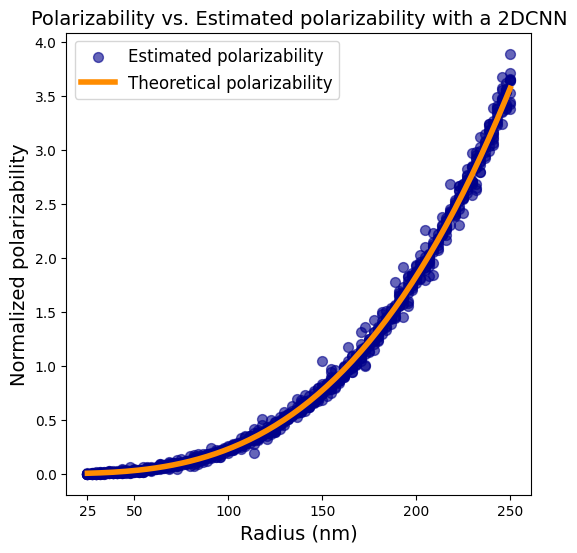

In [61]:
plt.figure(figsize=(6, 6))
plt.scatter(radiuses, pol_cnn_fix_ri, color="darkblue", alpha=0.6, s=50, label='Estimated polarizability')

#Line for theoretical
plt.plot(radiuses, theoretical_pol, linestyle="-", linewidth=4, label="Theoretical polarizability", color='darkorange')

plt.xticks([25e-9, 50e-9, 100e-9, 150e-9, 200e-9, 250e-9], ["25", "50", "100", "150", "200", "250"])
plt.xlabel("Radius (nm)", fontsize=14)
plt.ylabel("Normalized polarizability", fontsize=14)
plt.legend(fontsize=12)
plt.title("Polarizability vs. Estimated polarizability with a 2DCNN", fontsize=14)

#### 3.4.1 Fix radius

The radius is set to 100nm for all particles. Note that, in the quantitative field regime the polarizability should scale linearly when keeping the radius fixed.

In [62]:
FIX_RADIUS = 100e-9
RI_RANGE = np.linspace(1.37, 1.6, 100)
samples_per_case = 10
riis = np.concatenate([np.repeat(x, samples_per_case) for x in RI_RANGE])

In [63]:
DATA = []
for i, ri in enumerate(RI_RANGE):
    if i % 10 == 0:
        print(f"Simulating... {i}/100")

    #Get all the particles
    for _ in range(samples_per_case):
        im = dataset.update().resolve(refractive_index=ri, radius=FIX_RADIUS)
        DATA.append(im)
DATA = np.array(DATA)


Simulating... 0/100
Simulating... 10/100
Simulating... 20/100
Simulating... 30/100
Simulating... 40/100
Simulating... 50/100
Simulating... 60/100
Simulating... 70/100
Simulating... 80/100
Simulating... 90/100


In [64]:
# Get the theoretical polarizabilities
theoretical_pol = hp.get_polarizability(FIX_RADIUS*1e6, riis)

In [65]:
#Predict the polarizabilities on the data
pol_cnn_fix_radius = cnn_regressor(
    torch.from_numpy(DATA).permute(0, 3, 1, 2).float().to(DEV)
    ).cpu().detach().numpy()[:, 0]

In [66]:
#Normalize the signals
pol_cnn_fix_radius = pol_cnn_fix_radius / pol_cnn_fix_radius.mean()
theoretical_pol = theoretical_pol / theoretical_pol.mean()

Text(0.5, 1.0, 'Polarizability vs. Estimated polarizability with a 2DCNN')

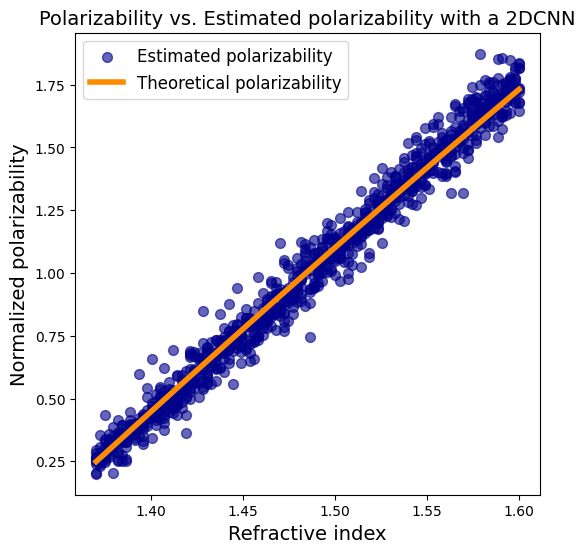

In [67]:
plt.figure(figsize=(6, 6))
plt.scatter(riis, pol_cnn_fix_radius, color="darkblue", alpha=0.6, s=50, label='Estimated polarizability')

#Line for theoretical
plt.plot(riis, theoretical_pol, linestyle="-", linewidth=4, label="Theoretical polarizability", color='darkorange')
plt.xlabel("Refractive index", fontsize=14)
plt.ylabel("Normalized polarizability", fontsize=14)
plt.legend(fontsize=12)
plt.title("Polarizability vs. Estimated polarizability with a 2DCNN", fontsize=14)

## 4. Combining detection and quantification in Holography

Lastly we provide a example on how to combine detection and quantification on a full frame.

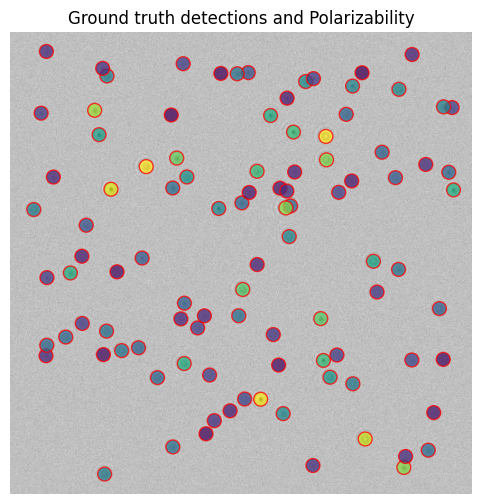

In [68]:
hp.plot_frame_with_detections_filled(
    data=data[...,1],
    positions=centroids,
    values=polarizabilities_rois,
    title="Ground truth detections and Polarizability"
    )

### 4.1 LodeSTAR and 2DCNN for particle detection and quantification on a full frame


In [69]:
def LodeSTAR_2dcnn_full_frame_pipeline(data, lodestar, cnn_regressor, alpha=0.5, beta=0.5, cutoff=0.95, padsize=20, downsample=False):
    """
    Pipeline for detecting particles in a full frame darkfield image and predicting the signal strength.

    Args:
        data (np.array): The full frame darkfield image.
        lodestar (LodeSTAR): The LodeSTAR model.
        cnn_regressor (torch.nn.Module): The CNN regressor model.
        alpha (float): The alpha parameter for LodeSTAR.
        beta (float): The beta parameter for LodeSTAR.
        cutoff (float): The cutoff parameter for LodeSTAR.
        padsize (int): The padding size for the ROIs.
        downsample (bool): If True, downsample the image by a factor of 2.

    Returns:
        A tuple with the detections and the signals.
    """

    #Detect particles with LodeSTAR
    if downsample:
        datav2 = skimage.measure.block_reduce(data, (2, 2, 1)) 
        torch_image = torch.from_numpy(datav2).permute(2, 0, 1).unsqueeze(0).float().to(DEV)
        factor = 2
    else:
        torch_image = torch.from_numpy(data).permute(2, 0, 1).unsqueeze(0).float().to(DEV)
        factor = 1

    detections = lodestar.detect(torch_image, alpha=alpha, beta=beta, 
                                    mode="quantile", cutoff=cutoff)[0] * factor

    #If no detections, throw error.
    if len(detections) > 0:
        
        #Check so detections is not out of bounds
        detections = detections[(detections[:,0] > padsize) & (detections[:,0] < data.shape[0] - padsize) & 
                                (detections[:,1] > padsize) & (detections[:,1] < data.shape[1] - padsize)]

        #Get the signals
        signals = np.array([
            cnn_regressor(torch.from_numpy(roi).permute(2, 0, 1).unsqueeze(0).float().to(DEV)).cpu().detach().numpy()[0, 0] 
            for roi in hp.get_rois(data, detections, padsize)])

        return detections, signals

    else:
        print("No detections")

In [70]:
detections, signals = LodeSTAR_2dcnn_full_frame_pipeline(
    data, 
    lodestar, 
    cnn_regressor, 
    alpha=alpha, 
    beta=beta, 
    cutoff=cutoff, 
    padsize=padsize, 
    )

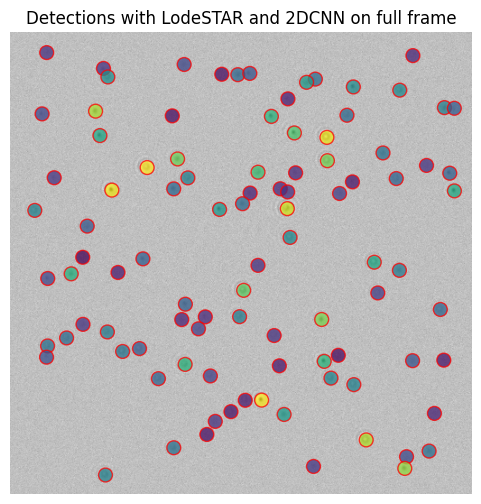

In [71]:
hp.plot_frame_with_detections_filled(
    data=data[...,1],
    positions=detections,
    values=signals,
    title="Detections with LodeSTAR and 2DCNN on full frame"
    )